Based on: https://medium.com/howtoai/video-classification-with-cnn-rnn-and-pytorch-abe2f9ee031

In [1]:
import os
import numpy

path2original = "./data/original"
path2augmented = "./data/augmented"

original_fields = numpy.array(sorted(os.listdir(path2original)))

In [2]:
from torchvision.transforms.functional import to_pil_image

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)        
    return x

Split the videos into two groups:

In [3]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_idx, test_idx = next(sss.split(original_fields))

train_original_fields = [original_fields[ind] for ind in train_idx]
test_original_fields = [original_fields[ind] for ind in test_idx]

augmented_fields = numpy.array(sorted(os.listdir(path2augmented)))

train_fields = [field for field in augmented_fields if field.startswith(tuple(train_original_fields))]
test_fields = [field for field in augmented_fields if field.startswith(tuple(test_original_fields))]

In [4]:
# Data set
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random

np.random.seed(2021)
random.seed(2021)
torch.manual_seed(2021)

def extractLabel(imageName):
    if "sowing" in imageName:
        return 1
    elif "nothing" in imageName:
        return 0
    elif "posle" in imageName:
        return -1
    else:
        raise "No type found..."

class FieldsDataset(Dataset):
    def __init__(self, fields, transform, seq_length, step):
        self.transform = transform
        
        self.fields = fields

        self.sequences = []
        self.labels = []
        for field in fields:
            path = f'{path2augmented}/{field}/'
            #print(f'Processing field {field}')
            
            imageNames = []
            for root, dirs, files in os.walk(path):
                imageNames = sorted(files)
            
            # Remove "posle" images
            labelToMap = { name : extractLabel(name) for name in imageNames }
            imageNames = [name for name in imageNames if labelToMap[name] != -1 ]
            
            #print(imageNames)
            
            for i in range(0, len(imageNames), step):
                seqImageNames = []
                
                shouldBreak = False
                if (i >= len(imageNames) - seq_length):
                    shouldBreak = True
                    seqImageNames = imageNames[-seq_length:]
                else:
                    seqImageNames = imageNames[i : i + seq_length]

                label = 0
                if any(labelToMap[name] == 1 for name in seqImageNames):
                    label = 1
                self.labels.append(label)
                
                seqImagePaths = [path + name for name in seqImageNames]
                self.sequences.append(seqImagePaths);

                #print(f'Label {label}')
                #print(f'Pathes {seqImagePaths}')
                
                if shouldBreak:
                    break
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seqOfPaths = self.sequences[idx]

        frames = []
        for imagePath in seqOfPaths:
            frame = Image.open(imagePath).convert('RGB') # Converting to RGB to make sure the tensor of 3 layers
            frames.append(frame)
            
        seed = np.random.randint(1e9)
        frames_tr = []
        for ii, frame in enumerate(frames):
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
            
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)

        return frames_tr, self.labels[idx]
    
    def get(self, idx, model_type): # In order to get training 
        seqOfPaths = self.sequences[idx]

        frames = []
        for imagePath in seqOfPaths:
            frame = Image.open(imagePath).convert('RGB') # Converting to RGB to make sure the tensor of 3 layers
            frames.append(frame)
            
        seed = np.random.randint(1e9)
        frames_tr = []
        for ii, frame in enumerate(frames):
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
            
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)

        if model_type=="3dcnn":
            frames_tr = torch.transpose(frames_tr, 1, 0)
        frames_tr = frames_tr.unsqueeze(0)

        return frames_tr

In [5]:
# Transformation

# Params

# choose one
model_type = "3dcnn"
#model_type = "rnn"

seq_length = 6
seq_step = 6

if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

# Transforms

import torchvision.transforms as transforms

train_transformer = transforms.Compose([
        transforms.Resize((h,w)),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomAffine(degrees=0,
        #                        translate=(0.1,0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
])

In [6]:
# Create dataset
train_ds = FieldsDataset(fields=train_fields, transform=train_transformer, seq_length=seq_length, step=seq_step)
print(len(train_ds))

650


In [7]:
imgs, label = train_ds[9]
if len(imgs)>0:
    print(imgs.shape, torch.min(imgs), torch.max(imgs))

torch.Size([6, 3, 112, 112]) tensor(-1.8952) tensor(2.1845)


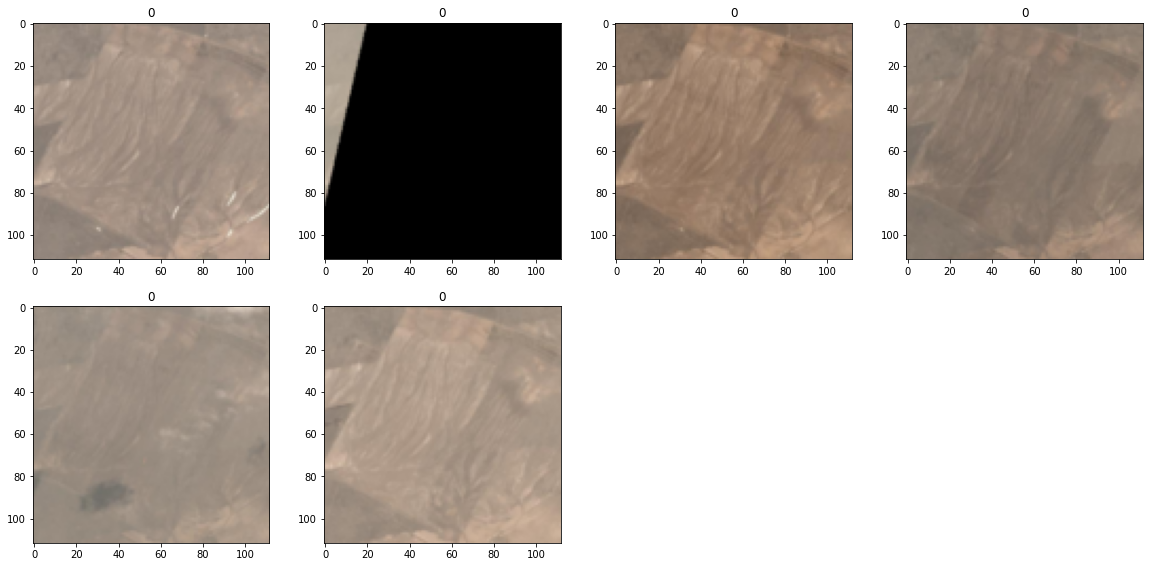

In [8]:
# Sample frames
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(20,20))
for ii,img in enumerate(imgs[:8]):
    plt.subplot(4,4,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

In [9]:
# Test data trasnform
test_transformer = transforms.Compose([
    transforms.Resize((h,w)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_ds = FieldsDataset(fields=test_fields, transform=test_transformer, seq_length=seq_length, step=seq_step)
print(len(test_ds))

78


In [10]:
imgs, label = test_ds[3]
imgs.shape, torch.min(imgs), torch.max(imgs)

(torch.Size([6, 3, 112, 112]), tensor(-0.6686), tensor(2.8014))

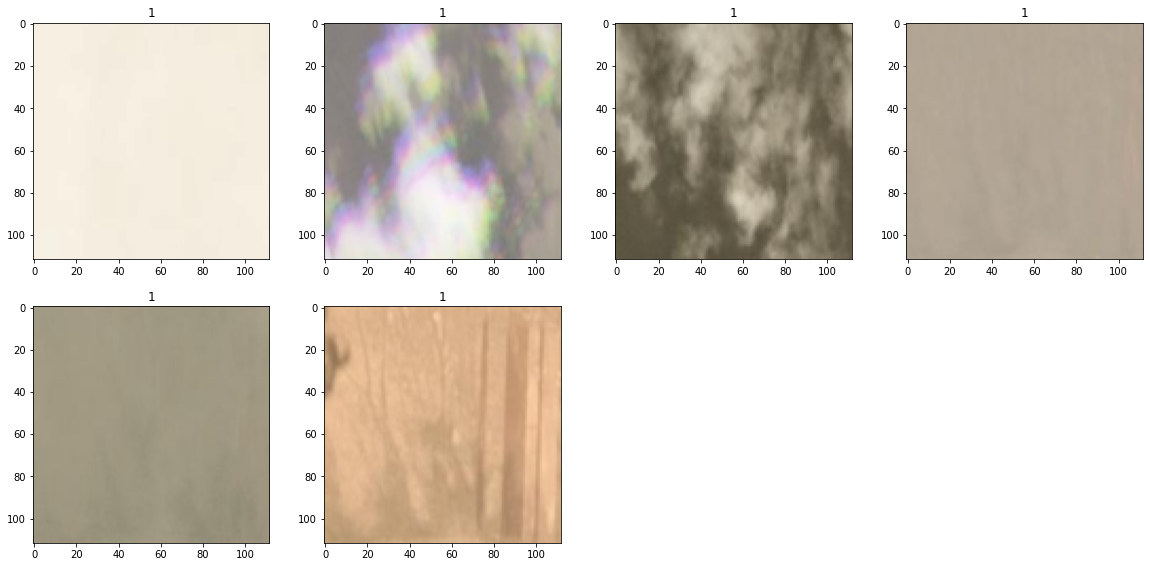

In [11]:
plt.figure(figsize=(20,20))
for ii,img in enumerate(imgs[:8]):
    plt.subplot(4,4,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

In [12]:
# Data Loaders

def collate_fn_3dcnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor
    

batch_size = 16 # NOTE HERE
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=False, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, shuffle=False, collate_fn= collate_fn_rnn)
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=False, collate_fn= collate_fn_3dcnn)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, shuffle=False, collate_fn=collate_fn_3dcnn)

In [13]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([16, 3, 6, 112, 112]) torch.Size([16])


In [14]:
for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([32, 3, 6, 112, 112]) torch.Size([32])


# Defining model

In [15]:
from torch import nn
class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        
        baseModel = models.resnet18(pretrained=pretrained)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out) 
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [16]:
from torchvision import models
from torch import nn

num_classes = 2 # We have only two classes

if model_type == "rnn":
    params_model={
        "num_classes": num_classes,
        "dr_rate": 0.1, #0.1
        "pretrained" : True, #True
        "rnn_num_layers": 1, # 1
        "rnn_hidden_size": 100,} #100
    model = Resnt18Rnn(params_model)        
else:
    model = models.video.r3d_18(pretrained=False, progress=False) # pretrained=True
    #model = models.video.r2plus1d_18(pretrained=False, progress=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

In [17]:
with torch.no_grad():
    if model_type=="rnn":
        x = torch.zeros(1, seq_length, 3, h, w) #x = torch.zeros(1, 16, 3, h, w)
    else:
        x = torch.zeros(1, 3, seq_length, h, w) #x = torch.zeros(1, 3, 16, h, w)
    y= model(x)
    print(y.shape)

torch.Size([1, 2])


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
model

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [20]:
#path2weights = "./models/weights.pt"
#torch.save(model.state_dict(), path2weights)

# Training Model

In [21]:
import copy
from tqdm import tqdm_notebook

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": [],
    }
    
    metric_history={
        "train": [],
        "val": [],
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
    
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in tqdm_notebook(dataset_dl):
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss+=loss_b
        
        if metric_b is not None:
            running_metric+=metric_b
        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric

def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [22]:
# import torch
# torch.cuda.empty_cache()

# import gc
# del variables
# gc.collect()

from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1) #factor=0.5, patience=5,verbose=1
os.makedirs("./models", exist_ok=True)

params_train={
    "num_epochs": 20, #40, #20
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": "./models/weights_"+model_type+".pt",
    }
model,loss_hist,metric_hist = train_val(model,params_train)

Epoch 0/19, current lr=3e-05


<ipython-input-21-09f0ae30a6c2>:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for xb, yb in tqdm_notebook(dataset_dl):


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.017904, dev loss: 0.298611, accuracy: 26.92
----------
Epoch 1/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.004324, dev loss: 0.268756, accuracy: 26.92
----------
Epoch 2/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.001410, dev loss: 0.229048, accuracy: 41.03
----------
Epoch 3/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000594, dev loss: 0.184070, accuracy: 41.03
----------
Epoch 4/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000298, dev loss: 0.140624, accuracy: 41.03
----------
Epoch 5/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000170, dev loss: 0.102856, accuracy: 41.03
----------
Epoch 6/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000106, dev loss: 0.072907, accuracy: 41.03
----------
Epoch 7/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000072, dev loss: 0.050713, accuracy: 41.03
----------
Epoch 8/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000051, dev loss: 0.035035, accuracy: 41.03
----------
Epoch 9/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000038, dev loss: 0.024319, accuracy: 41.03
----------
Epoch 10/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000029, dev loss: 0.017094, accuracy: 41.03
----------
Epoch 11/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000023, dev loss: 0.012248, accuracy: 41.03
----------
Epoch 12/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000019, dev loss: 0.008999, accuracy: 41.03
----------
Epoch 13/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000016, dev loss: 0.006809, accuracy: 41.03
----------
Epoch 14/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000014, dev loss: 0.005331, accuracy: 41.03
----------
Epoch 15/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000012, dev loss: 0.004330, accuracy: 41.03
----------
Epoch 16/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000011, dev loss: 0.003655, accuracy: 41.03
----------
Epoch 17/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000009, dev loss: 0.003215, accuracy: 41.03
----------
Epoch 18/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000009, dev loss: 0.002957, accuracy: 41.03
----------
Epoch 19/19, current lr=3e-05


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000008, dev loss: 0.002836, accuracy: 41.03
----------


In [186]:
def plot_loss(loss_hist, metric_hist):

    num_epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

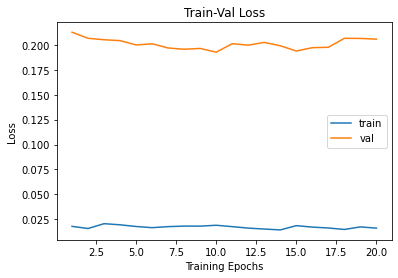

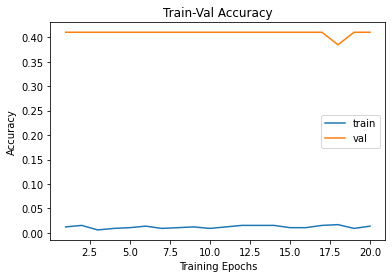

In [187]:
plot_loss(loss_hist, metric_hist)

torch.Size([1, 6, 3, 224, 224]) tensor(-0.7936) tensor(2.5877)
torch.Size([1, 2])
tensor([[-0.3979,  0.0250]])
1


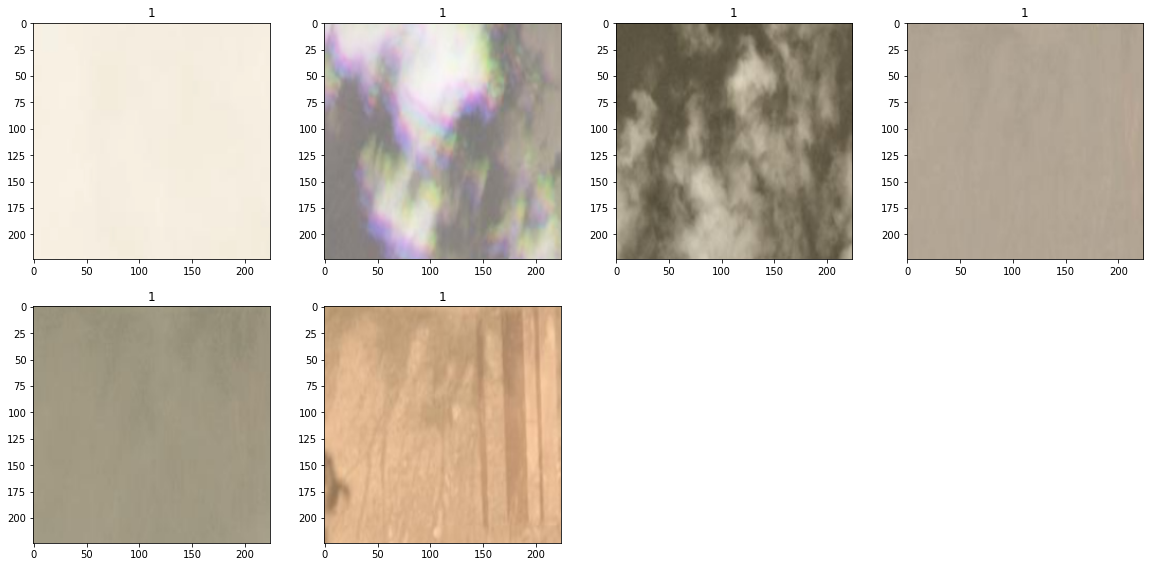

In [211]:
idx = 0
imgs = test_ds.get(idx, label)

print(imgs.shape, torch.min(imgs),torch.max(imgs))

with torch.no_grad():
    out = model(imgs.to(device)).cpu()
    print(out.shape)
    pred = torch.argmax(out).item()
    print(out)
    print(pred)

imgs, label = test_ds[idx]

plt.figure(figsize=(20,20))
for ii,img in enumerate(imgs[:8]):
    plt.subplot(4,4,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)